
Running Example 1:
Gen 0. Best bins: 50, Worst bins: 55, Range: 5, Avg: 51.26, Std: 0.71
Ticks CPU: 0.2333, Elapsed: 0.2336s
Gen 1. Best bins: 49, Worst bins: 55, Range: 6, Avg: 51.24, Std: 0.73
Ticks CPU: 10.8760, Elapsed: 10.9226s
Gen 2. Best bins: 49, Worst bins: 56, Range: 7, Avg: 51.25, Std: 0.72
Ticks CPU: 20.5021, Elapsed: 20.6034s
Gen 3. Best bins: 49, Worst bins: 55, Range: 6, Avg: 51.25, Std: 0.72
Ticks CPU: 30.0604, Elapsed: 30.2184s
Gen 4. Best bins: 49, Worst bins: 55, Range: 6, Avg: 51.25, Std: 0.73
Ticks CPU: 39.0832, Elapsed: 39.2654s
Gen 5. Best bins: 49, Worst bins: 55, Range: 6, Avg: 51.25, Std: 0.73
Ticks CPU: 49.0173, Elapsed: 49.2698s
Time limit exceeded.
Finished after 6 generations.
Wall-clock time: 49.27s, CPU time: 49.02s

Running Example 2:
Gen 0. Best bins: 50, Worst bins: 55, Range: 5, Avg: 51.71, Std: 0.65
Ticks CPU: 0.3388, Elapsed: 0.3451s
Gen 1. Best bins: 50, Worst bins: 55, Range: 5, Avg: 51.71, Std: 0.67
Ticks CPU: 10.5353, Elapsed: 10.6907s
Gen 2. 

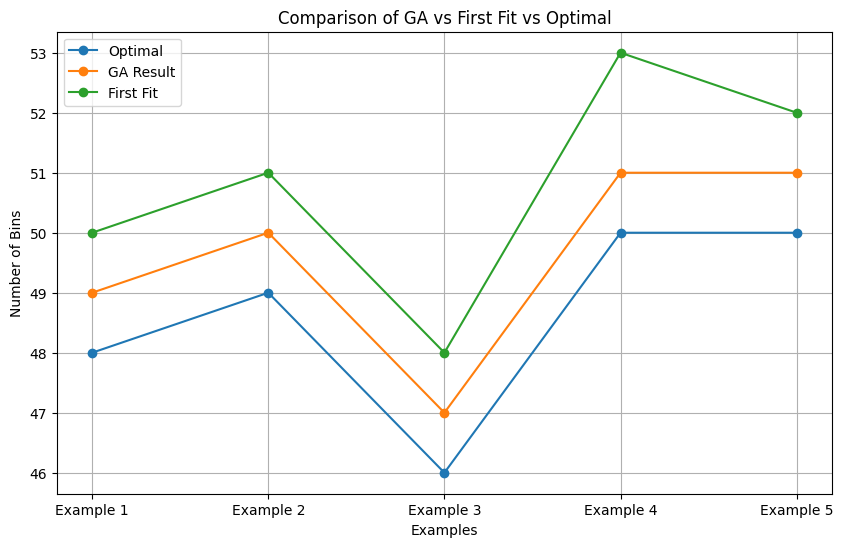

In [3]:
import random
import time
import math
import matplotlib.pyplot as plt

# GA Parameters (common)
GA_POPSIZE = 8192
GA_MAXITER = 1000
GA_ELITRATE = 0.01
GA_MUTATIONRATE = 0.2
NO_IMPROVEMENT_LIMIT = 20

# Problem Configuration
PROBLEM_TYPE = "BIN_PACKING"  # "STRING" or "BIN_PACKING"

# --- STRING Problem Parameters ---
GA_TARGET = "Hello world!"
GA_CHARSIZE = 90
CROSSOVER_TYPE = "UNIFORM"
FITNESS_MODE = "LCS"
PARENT_SELECTION_METHOD = "TOURNAMENT_STOCH"
TOURNAMENT_K = 5
TOURNAMENT_P = 0.8
SURVIVOR_SELECTION_METHOD = "AGING"
AGE_LIMIT = 15


# --- BIN PACKING Problem Parameters ---
DYNAMIC_MUTATION = True
STUCK_MUTATION_INCREASE = 0.4
STUCK_SHUFFLE_WORST = 0.3
EARLY_STOPPING_ENABLED = True  # Our new improvement

# Improvements Parameters
STUCK_LIMIT = 10   # How many generations without improvement to consider as stuck
DYNAMIC_MUTATION_MULTIPLIER = 2.0  # Increase mutation when stuck
DIVERSIFY_WORST_PERCENT = 0.3  # Shuffle worst 30% of population when stuck



class IndividualBinPacking:
    def __init__(self, items, bin_capacity):
        self.items = sorted(items)  # Always sorted for consistency
        self.bin_capacity = bin_capacity
        self.bins = []
        self.fitness = None
        self.age = 0
        self.random_packing()

    def random_packing(self):
        random.shuffle(self.items)
        self.bins = []
        for item in self.items:
            placed = False
            for bin in self.bins:
                if sum(bin) + item <= self.bin_capacity:
                    bin.append(item)
                    placed = True
                    break
            if not placed:
                self.bins.append([item])

    def calculate_fitness(self):
        packed_items = [item for bin in self.bins for item in bin]

        if sorted(packed_items) != sorted(self.items):
            # Missing or duplicated items -> Heavy penalty
            self.fitness = 9999
        else:
            # Valid solution: number of bins
            self.fitness = len(self.bins)


class PopulationBinPacking:
    def __init__(self, size, items, bin_capacity):
        self.size = size
        self.bin_capacity = bin_capacity
        self.individuals = self.init_population(items)
        self.best_fitness_list = []
        self.avg_fitness_list = []
        self.worst_fitness_list = []
        self.fitness_history = []

    def init_population(self, items):
        population = []
        for _ in range(self.size):
            individual = IndividualBinPacking(list(items), self.bin_capacity)
            individual.calculate_fitness()
            population.append(individual)
        return population
    def update_fitness(self):
        for ind in self.individuals:
            ind.calculate_fitness()

    def sort_by_fitness(self):
        self.individuals.sort(key=lambda ind: ind.fitness)

    def elitism(self, buffer, esize):
        for i in range(esize):
            buffer[i] = self.individuals[i]

    def generation_stats_update(self, generation):
        best_fit = self.individuals[0].fitness
        worst_fit = self.individuals[-1].fitness
        avg_fit = sum(ind.fitness for ind in self.individuals) / self.size
        fitness_range = worst_fit - best_fit
        variance = sum((ind.fitness - avg_fit)**2 for ind in self.individuals) / self.size
        std_dev = math.sqrt(variance)

        print(f"Gen {generation}. Best bins: {best_fit}, Worst bins: {worst_fit}, Range: {fitness_range}, Avg: {avg_fit:.2f}, Std: {std_dev:.2f}")

        self.best_fitness_list.append(best_fit)
        self.avg_fitness_list.append(avg_fit)
        self.worst_fitness_list.append(worst_fit)
        self.fitness_history.append([ind.fitness for ind in self.individuals])

    def fitness_plot(self):
        plt.figure(figsize=(10, 6))
        plt.plot(self.best_fitness_list, label="Best Fitness")
        plt.plot(self.avg_fitness_list, label="Average Fitness")
        plt.plot(self.worst_fitness_list, label="Worst Fitness")
        plt.title("Bin Packing Fitness Over Generations")
        plt.xlabel("Generation")
        plt.ylabel("Number of Bins")
        plt.legend()
        plt.grid(True)
        plt.show()

    def fitness_boxplot(self):
        for g, data in enumerate(self.fitness_history):
            plt.figure(figsize=(4, 5))
            plt.boxplot(data)
            plt.title(f"Box Plot of Bins - Gen {g}")
            plt.ylabel("Bins used")
            plt.show()


def mutate_bin_packing(individual, bin_capacity):
    if random.random() < GA_MUTATIONRATE :  # 30% chance do big mutation
        random.shuffle(individual.items)
        individual.random_packing()
    else:
        # Your existing swap logic
        if len(individual.bins) < 2:
            return
        bin1, bin2 = random.sample(individual.bins, 2)
        if not bin1 or not bin2:
            return
        item1 = random.choice(bin1)
        item2 = random.choice(bin2)
        if sum(bin1) - item1 + item2 <= bin_capacity and sum(bin2) - item2 + item1 <= bin_capacity:
            bin1.remove(item1)
            bin2.remove(item2)
            bin1.append(item2)
            bin2.append(item1)



def crossover_bin_packing(parent1, parent2, bin_capacity):
    # Always take original item list (not from parents' bins)
    items = list(parent1.items)
    random.shuffle(items)

    child_bins = []

    for item in items:
        placed = False
        for bin in child_bins:
            if sum(bin) + item <= bin_capacity:
                bin.append(item)
                placed = True
                break
        if not placed:
            child_bins.append([item])

    return IndividualBinPacking(items, bin_capacity)



def mate_bin_packing(population, buffer, mutation_rate):
    esize = int(GA_POPSIZE * GA_ELITRATE)
    population.elitism(buffer, esize)

    for i in range(esize, GA_POPSIZE):
        parent1 = random.choice(population.individuals[:GA_POPSIZE // 2])
        parent2 = random.choice(population.individuals[:GA_POPSIZE // 2])
        child = crossover_bin_packing(parent1, parent2, population.bin_capacity)

        if random.random() < mutation_rate:
            mutate_bin_packing(child, population.bin_capacity)

        child.calculate_fitness()
        buffer[i] = child


def run_bin_packing_ga(items, bin_capacity, max_time, optimal_bins_for_example):
    random.seed(time.time())
    population = PopulationBinPacking(GA_POPSIZE, items, bin_capacity)
    buffer = [None] * GA_POPSIZE

    start_wall_time = time.time()
    start_cpu_time = time.process_time()

    best_fit_so_far = float('inf')
    no_improvement_count = 0
    mutation_rate = GA_MUTATIONRATE  # Dynamic Mutation Copy

    for generation in range(GA_MAXITER):
        population.update_fitness()
        population.sort_by_fitness()
        population.generation_stats_update(generation)

        ticks_cpu = time.process_time() - start_cpu_time
        elapsed = time.time() - start_wall_time
        print(f"Ticks CPU: {ticks_cpu:.4f}, Elapsed: {elapsed:.4f}s")

        best_fitness = population.individuals[0].fitness

        # Early Stopping if Optimal Reached
        if best_fitness == optimal_bins_for_example:
            print("Early stopping - Optimal bins achieved!")
            break

        # Improvement Check
        if best_fitness < best_fit_so_far:
            best_fit_so_far = best_fitness
            no_improvement_count = 0
            mutation_rate = GA_MUTATIONRATE  # Reset mutation
        else:
            no_improvement_count += 1

        # Stuck Detection
        if no_improvement_count >= STUCK_LIMIT:
            #print("Stuck detected! Increasing mutation rate and diversifying worst individuals...")
            mutation_rate = GA_MUTATIONRATE * DYNAMIC_MUTATION_MULTIPLIER

            # Adaptive Diversification (shuffle worst X%)
            num_to_diversify = int(GA_POPSIZE * DIVERSIFY_WORST_PERCENT)
            for ind in population.individuals[-num_to_diversify:]:
                random.shuffle(ind.items)
                ind.random_packing()
                ind.calculate_fitness()

        if no_improvement_count >= NO_IMPROVEMENT_LIMIT:
            print("No improvement => Converged.")
            break

        if elapsed > max_time:
            print("Time limit exceeded.")
            break

        mate_bin_packing(population, buffer, mutation_rate)
        population.individuals, buffer = buffer, population.individuals

    total_wall = time.time() - start_wall_time
    total_cpu = time.process_time() - start_cpu_time

    print(f"Finished after {generation + 1} generations.")
    print(f"Wall-clock time: {total_wall:.2f}s, CPU time: {total_cpu:.2f}s")

    #population.fitness_plot()
    #population.fitness_boxplot()
    return population.individuals[0].fitness


def first_fit(items, bin_capacity):
    bins = []
    for item in items:
        placed = False
        for bin in bins:
            if sum(bin) + item <= bin_capacity:
                bin.append(item)
                placed = True
                break
        if not placed:
            bins.append([item])
    return bins

def main(max_time):
    if PROBLEM_TYPE == "STRING":
        #main_string_problem(max_time)
        print("String problem not implemented yet.")
    elif PROBLEM_TYPE == "BIN_PACKING":
      examples = [
          (150, 120, 48, [42,69,67,57,93,90,38,36,45,42,33,79,27,57,44,84,86,92,46,38,85,33,82,73,49,70,59,23,57,72,74,69,33,42,28,46,30,64,29,74,41,49,55,98,80,32,25,38,82,30,35,39,57,84,62,50,55,27,30,36,20,78,47,26,45,41,58,98,91,96,73,84,37,93,91,43,73,85,81,79,71,80,76,83,41,78,70,23,42,87,43,84,60,55,49,78,73,62,36,44,94,69,32,96,70,84,58,78,25,80,58,66,83,24,98,60,42,43,43,39]),
          (150, 120, 49, [97,57,81,62,75,81,23,43,50,38,60,58,70,88,36,90,37,45,45,39,44,53,70,24,82,81,47,97,35,65,74,68,49,55,52,94,95,29,99,20,22,25,49,46,98,59,98,60,23,72,33,98,80,95,78,57,67,53,47,53,36,38,92,30,80,32,97,39,80,72,55,41,60,67,53,65,95,20,66,78,98,47,100,85,53,53,67,27,22,61,43,52,76,64,61,29,30,46,79,66,27,79,98,90,22,75,57,67,36,70,99,48,43,45,71,100,88,48,27,39]),
          (150, 120, 46, [38,100,60,42,20,69,24,23,92,32,84,36,65,84,34,68,64,33,69,27,47,21,85,88,59,61,50,53,37,75,64,84,74,57,83,28,31,97,61,36,46,37,96,80,53,51,68,90,64,81,66,67,80,37,92,67,64,31,94,45,80,28,76,29,64,38,48,40,29,44,81,35,51,48,67,24,46,38,76,22,30,67,45,41,29,41,79,21,25,90,62,34,73,50,79,66,59,42,90,79,70,66,80,35,62,98,97,37,32,75,91,91,48,26,23,32,100,46,29,26]),
          (150, 120, 50, [23,48,78,85,92,39,31,76,87,54,61,66,40,22,74,99,96,73,24,43,93,47,51,22,49,39,21,72,93,72,49,68,71,82,44,25,82,74,59,28,33,61,90,97,62,42,100,50,31,84,81,27,45,84,54,34,79,100,63,48,68,46,74,65,35,66,53,27,70,86,49,45,86,74,64,73,93,34,97,80,24,87,100,75,89,78,46,31,68,63,78,28,96,54,64,31,65,90,41,47,71,51,63,44,93,46,46,83,68,57,89,35,99,39,24,69,64,25,85,65]),
          (150, 120, 50, [49,95,38,62,63,97,42,62,100,43,44,77,97,94,68,23,50,36,89,58,97,27,64,65,54,58,24,35,33,63,32,50,58,90,44,50,48,21,72,75,21,74,28,95,77,69,96,24,57,85,72,96,50,83,65,62,99,93,23,77,94,31,50,33,79,73,23,55,44,78,84,66,31,59,97,95,22,76,90,66,29,100,90,92,50,49,47,43,37,40,60,52,54,99,34,46,88,97,85,39,32,51,95,54,99,86,48,90,28,25,86,39,74,26,38,60,41,67,80,33])
      ]

      optimal_bins = []
      ga_bins = []
      first_fit_bins = []
      ga_runtimes = []
      ff_runtimes = []

      for idx, (bin_capacity, n, optimal, items) in enumerate(examples):
          print(f"\nRunning Example {idx+1}:")

          # GA
          start = time.time()
          best_ga_fitness = run_bin_packing_ga(items, bin_capacity, max_time, optimal)
          ga_runtime = time.time() - start
          ga_runtimes.append(ga_runtime)
          ga_bins.append(best_ga_fitness)

          # First Fit
          start = time.time()
          bins = first_fit(items, bin_capacity)
          ff_runtime = time.time() - start
          first_fit_bins.append(len(bins))
          ff_runtimes.append(ff_runtime)

          optimal_bins.append(optimal)

      # Plotting
      plt.figure(figsize=(10, 6))
      x = [f'Example {i+1}' for i in range(len(examples))]
      plt.plot(x, optimal_bins, label='Optimal', marker='o')
      plt.plot(x, ga_bins, label='GA Result', marker='o')
      plt.plot(x, first_fit_bins, label='First Fit', marker='o')
      plt.xlabel("Examples")
      plt.ylabel("Number of Bins")
      plt.title("Comparison of GA vs First Fit vs Optimal")
      plt.legend()
      plt.grid(True)
      plt.show()
    else:
        raise ValueError("Invalid PROBLEM_TYPE! Use 'STRING' or 'BIN_PACKING'.")

if __name__ == "__main__":
    main(40)